# Homework 3 Arno Strouwen
## Part 2
In this notebook we segment the foreground from the background of the VOC2012 dataset.
There is another notebook that contains an attempt at segmenting all the classes.

In [9]:
from typing import List, Tuple
import os
import xml.etree.ElementTree as etree
from PIL import Image
import random
import pydot

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from tensorflow_examples.models.pix2pix import pix2pix

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

We first define some helper code to read in the data. The batch size is again chosen due to memory limitations of my GPU.

In [2]:
path_to_VOC_folder = os.path.join("VOCdevkit","VOC2012") # adjust path to your location
image_size = 128
batch_size = 32
_VOC_LABELS = (
    "aeroplane","bicycle","bird","boat","bottle",
    "bus","car","cat","chair","cow",
    "diningtable","dog","horse","motorbike","person",
    "pottedplant","sheep","sofa","train","tvmonitor",
)
def get_segmentation_paths(base_dir):
  IMAGE_PATH = os.path.join(base_dir,'JPEGImages')
  ANNOTATION_PATH = os.path.join(base_dir,'SegmentationClass')
  LISTS=os.path.join(base_dir,'ImageSets','Segmentation')
  image_files_paths = []
  annotations_paths = []
  names=[]
  with open(os.path.join(LISTS,'trainval.txt' )) as f:
    for line in f:
      names.append(line[:-1])
    
  for name in names:
    image_files_paths.append(os.path.join(IMAGE_PATH,name+'.jpg'))
    annotations_paths.append(os.path.join(ANNOTATION_PATH, name+'.png'))

  return image_files_paths, annotations_paths

def get_mask(path):
  mask =np.array(Image.open(path.numpy()).resize((image_size,image_size)))
  return mask

def _load_image_and_mask_py(im_path,mask_path):
  img_raw = tf.io.read_file(im_path)
  img = tf.io.decode_image(img_raw, dtype=tf.dtypes.uint8,expand_animations = False)
  img=tf.image.resize(img,(image_size,image_size),preserve_aspect_ratio=False,antialias=True)

  # tf.io.decode_image does not recognize the png file properly, we need to load it with PIL
  mask =np.array(Image.open(mask_path.numpy()).resize((image_size,image_size)))

  # uncomment as needed:
  # foreground/background segmentation:
  mask[mask>0]=1

  # segment all classes:
  #mask[mask==255]=21
  # 255 is a outline/difficult label. You can predict this as a 21st class, or ignore it by setting =0
  return img,mask

def load_image_and_mask(x,y,preprocess,augment):
  # this is needed because we need to load the masks from png files using the PIL library.
  # This is done inside a tf.py_function to prevent tf from running this part of the ds in a graph.
  x,y= tf.py_function(func=_load_image_and_mask_py,inp=[x,y], Tout=(tf.float32,tf.uint8))
  # The output shape of tf.py_fucntions are unknown, this will cause issues when compiling models with metrics
  # and runing model.fit in graph execution (the default behaviour)
  x.set_shape(tf.TensorShape([None,None,None]))
  if preprocess:
      x = tf.keras.applications.mobilenet.preprocess_input(x)
  y.set_shape(tf.TensorShape([None,None]))
  # Could not get this part to work...
  #if augment:
    #seed1 =random.randint(0, 1_000_000_000)
    #seed2 =random.randint(0, 1_000_000_000)
    #seed3 =random.randint(0, 1_000_000_000)
    #da = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal",seed=seed1),
    #                       layers.experimental.preprocessing.RandomRotation(0.1,seed=seed2),
    #                       layers.experimental.preprocessing.RandomZoom(0.2,seed=seed3)])            
    #x = da(x)
    #y = da(y)

  return x,y
image_paths, annotation_paths = get_segmentation_paths(path_to_VOC_folder)

We use 80% of the data for training 10% for hyper parameter tuning and 10% for testing the performance of the final model.

In [3]:
X_train, X_rest, y_train, y_rest=train_test_split(image_paths, annotation_paths,
                                                  train_size=0.8, shuffle=True, random_state=2022)
X_val, X_test, y_val, y_test=train_test_split(X_rest, y_rest,
                                                  train_size=0.5, shuffle=True, random_state=2022)
print(f'train samples: {len(X_train)} \nval samples: {len(X_val)} \ntest samples: {len(X_test)}')

train samples: 2330 
val samples: 291 
test samples: 292


We follow the tensorflow tutorial on image segmentation, which uses the MobileNet architecture for automatic feature discovery. Again, this architecture requires the images to be preprocessed a certain way. After the downsampling part of the architecture, the discovered features need to be upsampled again to a segmentation mask. This is done using upsample layers from the pix2pix architecture. The important difference with the architecture used in the textbook, in section 9.2, is the presence of skip connections, e.g. downsampled layers of size 64x64 are concatenated to the upsamled layers of size 64x64. These connections should reduce the vanishing gradient problem and speed up training.

In [4]:
def create_data_set(X,Y,preprocess,augment):
    ds=tf.data.Dataset.from_tensor_slices((X,Y))
    ds=ds.shuffle(buffer_size=5000)
    ds=ds.map(lambda x,y :load_image_and_mask(x,y,preprocess,augment),num_parallel_calls=tf.data.AUTOTUNE)
    ds=ds.prefetch(tf.data.AUTOTUNE)
    ds=ds.batch(batch_size)
    return ds

ds_train_pp = create_data_set(X_train,y_train,True,False)
ds_val_pp = create_data_set(X_val,y_val,True,False)
ds_test_pp = create_data_set(X_test,y_test,True,False)
ds_test_no_pp = create_data_set(X_test,y_test,False,False)

In [5]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[image_size, image_size, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = True
# mask from features model
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

Binary crossentropy calculates the loss on a per pixel basis, and might be problematic if there is large class imbalance, i.e. most pixels are from the background, thus a model that only predicts background would already perform well according to this loss. Several losses have been suggested in the literature that try to alleviate this problem, such as the dice loss (https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient). Looking at the definition of this loss, it does not directly focus on improving the true negatives, i.e. accurately predicting the background, instead it focusses on improving the harmonic mean of the precision and recall of foreground detection.

In [6]:
def diceloss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)
  return 1 - numerator / denominator

Again, we perform hyperparameter tuning. This time we fine-tune an exponentially decaying learning schedule, as well as fine tuning the last layer of the architecture. We find that a fast learning rate, that does not decay much is preferred. For the final label, Conv2DTranspose is preferred over upsampling and a regular convolution. This makes sense given the book's exposition in section 9.2 about avoiding the use of MaxPooling2D layers in downsampling, since it destroys spatial location information, instead convolutions with strides should be used. It is a reasonable hypothesis that the same holds true for upsampling.

In [7]:
output_channels = 2
def build_model(hp):
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-3, sampling="log")
    learning_decay = hp.Float("decay", min_value=0.5, max_value=0.99)
    last_layer_Conv2DTranspose = hp.Boolean("last")

    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    if last_layer_Conv2DTranspose: 
        last = tf.keras.layers.Conv2DTranspose( filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid')  #64x64 -> 128x128
    else:
        x = layers.UpSampling2D()(x)
        last = layers.Conv2D(filters=1, kernel_size=3, padding='same', activation='sigmoid')
    outputs = last(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,decay_steps=1,decay_rate=learning_decay)
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=schedule),
                  #loss= diceloss,
                  loss=diceloss,
                  metrics=['accuracy'])
    return model

In [10]:
tuner = kt.BayesianOptimization(
    build_model,
    objective="val_loss",
    max_trials=50,
    executions_per_trial=1,
    directory="BO3",
    overwrite=False,
)
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]
tuner.search(ds_train_pp,epochs=50,validation_data=ds_val_pp,callbacks=callbacks,verbose=2)

INFO:tensorflow:Reloading Oracle from existing project BO3\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from BO3\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     input_7[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[5][4]                      
__________________________________________________________________________________________________
concatenate_20 (Concatenate)    (None, 8, 8, 1088)   0           sequential[5][0]                 
                                                                 model[5][3]                

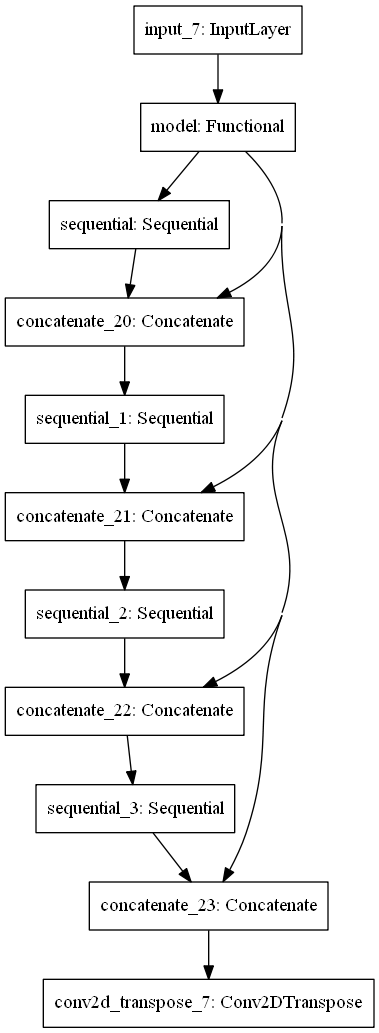

In [31]:
ds_full_train_pp = ds_train_pp.concatenate(ds_val_pp)
best_hps = tuner.get_best_hyperparameters(1)
final_model_structure =  build_model(best_hps[0])
final_model_structure.summary()
tf.keras.utils.plot_model(final_model_structure)

Early optimization exits, during hyperparameter tuning, based on the stagnation of the validation loss, were triggered around 17 epochs (sadly not saved in the output), thus we train the final model on both the training and validation data with a slightly larger number of epochs.

In [32]:
history = final_model_structure.fit(ds_full_train_pp , epochs=20)

Epoch 1/20
83/83 [==============================] - 16s 127ms/step - loss: 0.5120 - accuracy: 0.7268
Epoch 2/20
83/83 [==============================] - 11s 128ms/step - loss: 0.4271 - accuracy: 0.8339
Epoch 3/20
83/83 [==============================] - 11s 127ms/step - loss: 0.3947 - accuracy: 0.8691
Epoch 4/20
83/83 [==============================] - 11s 127ms/step - loss: 0.3815 - accuracy: 0.8802
Epoch 5/20
83/83 [==============================] - 11s 128ms/step - loss: 0.3767 - accuracy: 0.8833
Epoch 6/20
83/83 [==============================] - 11s 127ms/step - loss: 0.3745 - accuracy: 0.8848
Epoch 7/20
83/83 [==============================] - 11s 127ms/step - loss: 0.3737 - accuracy: 0.8852
Epoch 8/20
83/83 [==============================] - 11s 129ms/step - loss: 0.3727 - accuracy: 0.8860
Epoch 9/20
83/83 [==============================] - 11s 135ms/step - loss: 0.3735 - accuracy: 0.8854
Epoch 10/20
83/83 [==============================] - 11s 128ms/step - loss: 0.3715 - accura

Finally, we evaluate the model on the test set. The dice score of the model is equal to 0.57 and 85% of the pixels are classified correctly.

In [33]:
results = final_model_structure.evaluate(ds_test_pp)

10/10 [==============================] - 2s 62ms/step - loss: 0.4297 - accuracy: 0.8548


images


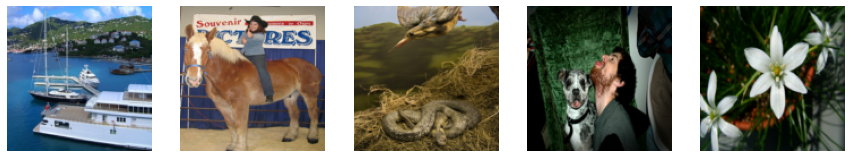

true mask


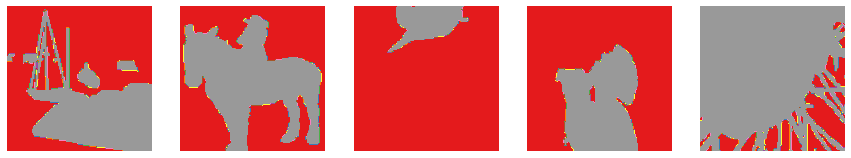

predicted mask


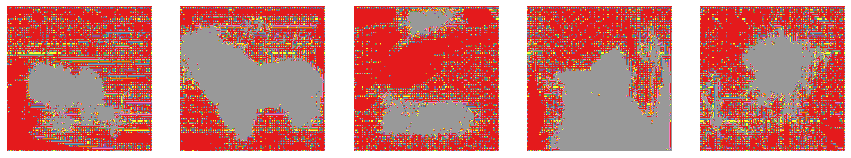

In [28]:
x,y = iter(ds_test_no_pp).next()
preds = final_model_structure.predict(tf.keras.applications.mobilenet.preprocess_input(x))
num_images = 5
print("images")
plt.figure(figsize=(15,15))
for i in range(num_images):
  ax=plt.subplot(1,num_images,i+1)
  ax.imshow(x[i].numpy().astype('uint8'))
  ax.axis('off')
plt.show()
print("true mask")
plt.figure(figsize=(15,15))
for i in range(num_images):
  ax=plt.subplot(1,num_images,i+1)
  ax.imshow(y[i].numpy().astype('uint8'), cmap='Set1')
  ax.axis('off')
plt.show()
print("predicted mask")
plt.figure(figsize=(15,15))
for i in range(num_images):
  ax=plt.subplot(1,num_images,i+1)
  masker = preds[i]>0.5
  ax.imshow(masker, cmap='Set1')
  ax.axis('off')
plt.show()

The horse + person and dog + person images are segmented quite well. It is a forgivable error that the snake also gets added to the foreground (even though it was not  one of the original classes). Similarly, it is understandable that the dark corner gets added to the background of the potted plant figure. The model performs remarkably well, given the time and computational effort that went into it.

One important aspect that I did not finish implementing is data augmentation. The segmentation dataset is much smaller than the classification dataset from part 1, probably because manually labelling the images is very labour intensive. Data augmentation might still significantly boost the performance of the model. The issue is that the same augmentation has to be performed both the image and the segmentation mask. I could not figure out how to do this with a tensorflow Dataset, as the textbook does not contain much information how Dataset works under the hood.